# Importing Libraries

In [1]:
import torch
import numpy as np
from torchvision.datasets import MNIST
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import warnings

from art.estimators.classification import PyTorchClassifier

warnings.filterwarnings('ignore')


/Applications/anaconda3/envs/compsci682/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
torch.manual_seed(0)
np.random.seed(0)

In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [2, 2]

In [4]:
!pip install adversarial-robustness-toolbox

# Loading MNIST dataset

### Change the directory storing data!

In [5]:
train_dataset = MNIST('data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = MNIST('data', train=False, download=True, transform=transforms.ToTensor())

Size of a single data

In [6]:
train_dataset[1000][0].size()

torch.Size([1, 28, 28])

Class related to this data

In [7]:
train_dataset[1000][1]

0

Visualize this data

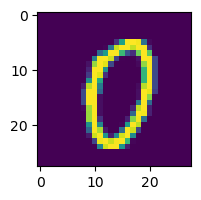

In [8]:
plt.imshow(train_dataset[1000][0].permute(1, 2, 0))

# Setting Hyperparameters

In [9]:
total_train_size = len(train_dataset)
total_test_size = len(test_dataset)
#total_dev_size = len(dev_dataset)

classes = 10
input_dim = 28 * 28

num_clients = 10 # (N = 5)
rounds = 5
batch_size = 128
epochs_per_client = 1
learning_rate = 0.01
beta = 0.9 # Momentum

In [10]:
total_train_size,total_test_size#, total_dev_size

(60000, 10000)

# GPU Support

In [11]:
def get_device():
    if torch.backends.mps.is_available():
        device = torch.device("mps")
    elif torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    return device
    # return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader(DataLoader):
        def __init__(self, dl, device):
            self.dl = dl
            self.device = device

        def __iter__(self):
            for batch in self.dl:
                yield to_device(batch, self.device)

        def __len__(self):
            return len(self.dl)

device = get_device()

In [12]:
device

device(type='mps')

# Network

Define Network Architecture and Usefull functions

In [13]:
class FederatedNet(torch.nn.Module):
    def __init__(self, num_channels=1, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(num_channels, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, num_classes)

        self.track_layers = {'conv1': self.conv1, 'conv2': self.conv2, 'fc1': self.fc1, 'fc2': self.fc2}

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2))
        x = x.view(-1, x.shape[1]*x.shape[2]*x.shape[3])
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

    def get_track_layers(self):
        return self.track_layers

    def apply_parameters(self, parameters_dict):
        with torch.no_grad():
            for layer_name in parameters_dict:
                self.track_layers[layer_name].weight.data *= 0
                self.track_layers[layer_name].bias.data *= 0
                self.track_layers[layer_name].weight.data += parameters_dict[layer_name]['weight']
                self.track_layers[layer_name].bias.data += parameters_dict[layer_name]['bias']

    def get_parameters(self):
        parameters_dict = dict()
        for layer_name in self.track_layers:
            parameters_dict[layer_name] = {
                'weight': self.track_layers[layer_name].weight.data,
                'bias': self.track_layers[layer_name].bias.data
            }
        return parameters_dict

    def batch_accuracy(self, outputs, labels):
        with torch.no_grad():
            _, predictions = torch.max(outputs, dim=1)
            return torch.tensor(torch.sum(predictions == labels).item() / len(predictions))

    def predict(self, dataset, batch_size=128):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size), device)
        preds = []
        with torch.no_grad():
            for batch in dataloader:
                images, labels = batch
                outputs = self(images)
                print(outputs)
                preds.append(outputs)
        return preds
    
    
    def _process_batch(self, batch):
        images, labels = batch
        # print(batch)
        outputs = self(images)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        accuracy = self.batch_accuracy(outputs, labels)
        return (loss, accuracy)

    def fit(self, dataset, epochs, lr, batch_size=128, opt=torch.optim.SGD):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size, shuffle=True), device)
        optimizer = opt(self.parameters(), lr, momentum=beta)
        history = []
        for epoch in range(epochs):
            losses = []
            accs = []
            for batch in dataloader:
                loss, acc = self._process_batch(batch)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                loss.detach()
                losses.append(loss)
                accs.append(acc)
            avg_loss = torch.stack(losses).mean().item()
            avg_acc = torch.stack(accs).mean().item()
            history.append((avg_loss, avg_acc))
        return history

    def evaluate(self, dataset, batch_size=128):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size), device)
        losses = []
        accs = []
        with torch.no_grad():
            for batch in dataloader:
                loss, acc = self._process_batch(batch)
                losses.append(loss)
                accs.append(acc)
        avg_loss = torch.stack(losses).mean().item()
        avg_acc = torch.stack(accs).mean().item()
        return (avg_loss, avg_acc)
    

# Client

Defining the clinet class

In [14]:
class Client:
    def __init__(self, client_id, dataset):
        self.client_id = client_id
        self.dataset = dataset

    def get_dataset_size(self):
        return len(self.dataset)

    def get_dataset(self):
        return self.dataset

    def get_client_id(self):
        return self.client_id

    def train(self, parameters_dict):
        net = to_device(FederatedNet(), device)
        net.apply_parameters(parameters_dict)
        train_history = net.fit(self.dataset, epochs_per_client, learning_rate, batch_size)
        print('{}: Loss = {}, Accuracy = {}'.format(self.client_id, round(train_history[-1][0], 4), round(train_history[-1][1], 4)))
        return net.get_parameters()

# Implementing FedAvg

(All clients contribute equally and the target client does not use backdoor attack)


Client setup

In [18]:
examples_per_client

6000

In [15]:
examples_per_client = total_train_size // num_clients

client_datasets = random_split(train_dataset, [min(i + examples_per_client,
           total_train_size) - i for i in range(0, total_train_size, examples_per_client)])

clients = [Client('client_' + str(i), client_datasets[i]) for i in range(num_clients)]

In [17]:
global_net = to_device(FederatedNet(), device)
history = []
for i in range(rounds):
    print('Start Round {} ...'.format(i + 1))
    curr_parameters = global_net.get_parameters()
    new_parameters = dict([(layer_name, {'weight': 0, 'bias': 0}) for layer_name in curr_parameters])
    for client in clients:
        client_parameters = client.train(curr_parameters)
        fraction = client.get_dataset_size() / total_train_size
        for layer_name in client_parameters:
            new_parameters[layer_name]['weight'] += fraction * client_parameters[layer_name]['weight']
            new_parameters[layer_name]['bias'] += fraction * client_parameters[layer_name]['bias']
    global_net.apply_parameters(new_parameters)

    train_loss, train_acc = global_net.evaluate(train_dataset)
    test_loss, test_acc = global_net.evaluate(test_dataset)
    print('After round {}, train_loss = {}, test_loss = {}, test_acc = {}\n'.format(i + 1, round(train_loss, 4),
            round(test_loss, 4), round(test_acc, 4)))
    history.append((train_loss, test_loss))

Start Round 1 ...
client_0: Loss = 4.1713, Accuracy = 0.1871
client_1: Loss = 2.0771, Accuracy = 0.4104
client_2: Loss = 2.0765, Accuracy = 0.3646
client_3: Loss = 2.0794, Accuracy = 0.4036
client_4: Loss = 2.0757, Accuracy = 0.371
client_5: Loss = 2.0787, Accuracy = 0.404
client_6: Loss = 2.0972, Accuracy = 0.3528
client_7: Loss = 2.0936, Accuracy = 0.3938
client_8: Loss = 2.086, Accuracy = 0.4084
client_9: Loss = 2.0763, Accuracy = 0.3427
After round 1, train_loss = 4.3963, test_loss = 4.3996, test_acc = 0.1013

Start Round 2 ...
client_0: Loss = 2.39, Accuracy = 0.1028
client_1: Loss = 2.3912, Accuracy = 0.1047
client_2: Loss = 2.3735, Accuracy = 0.1027
client_3: Loss = 2.3757, Accuracy = 0.1053
client_4: Loss = 2.4004, Accuracy = 0.1052
client_5: Loss = 2.3913, Accuracy = 0.0994
client_6: Loss = 2.3696, Accuracy = 0.1017
client_7: Loss = 2.3781, Accuracy = 0.1041
client_8: Loss = 2.3893, Accuracy = 0.1079
client_9: Loss = 2.3753, Accuracy = 0.1069
After round 2, train_loss = 2.31, 

KeyboardInterrupt: 

## Separate data and label to add trigger (pattern)

In [17]:
test_data = []
test_label = []
for i in range(len(test_dataset)):
    test_data.extend(np.array(test_dataset[i][0]*255))
    test_label.append(test_dataset[i][1])
test_data = np.array(test_data)
test_label = np.array(test_label)


In [18]:
target_client_num = len(clients)-1
target_data = []
target_label = []
for i in range(clients[-1].get_dataset_size()):
    target_data.extend(np.array(clients[-1].get_dataset()[i][0]*255))
    target_label.append(clients[-1].get_dataset()[i][1])
target_label = np.array(target_label)
target_data = np.array(target_data)


# Refer to the adversarial-robust-toolbox

https://nbviewer.org/github/Trusted-AI/adversarial-robustness-toolbox/blob/main/notebooks/hidden_trigger_backdoor/poisoning_attack_hidden_trigger_pytorch.ipynb

https://nbviewer.org/github/Trusted-AI/adversarial-robustness-toolbox/blob/main/notebooks/poisoning_defense_activation_clustering.ipynb

In [19]:
from art.attacks.poisoning.backdoor_attack import PoisoningAttackBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd, add_single_bd, insert_image
from art.utils import load_mnist, preprocess

BACKDOOR_TYPE = "pattern"

max_val = np.max(target_data[0])

def add_modification(x):
    if BACKDOOR_TYPE == 'pattern':
        return add_pattern_bd(x, pixel_value=max_val)
    # elif BACKDOOR_TYPE == 'pixel':
    #     return add_single_bd(x, pixel_value=max_val)
    # elif BACKDOOR_TYPE == 'image':
    #     return insert_image(x, backdoor_path='../utils/data/backdoors/alert.png', size=(10, 10))
    else:
        raise("Unknown backdoor type")


In [20]:
def poison_dataset(x_clean, y_clean, percent_poison, poison_func):
    x_poison = np.copy(x_clean)
    y_poison = np.copy(y_clean)
    is_poison = np.zeros(np.shape(y_poison))

    sources=np.arange(10) # 0, 1, 2, 3, ...
    # targets=(np.arange(10) + 1) % 10 # 1, 2, 3, 4, ...
    targets=np.full(10,9)
    # print(targets)

    for i, (src, tgt) in enumerate(zip(sources, targets)):
        n_points_in_tgt = np.size(np.where(y_clean == tgt))
        num_poison = round((percent_poison * n_points_in_tgt) / (1 - percent_poison))
        # print(y_clean, src)
        src_imgs = x_clean[y_clean == src]

        n_points_in_src = np.shape(src_imgs)[0]
        indices_to_be_poisoned = np.random.choice(n_points_in_src, num_poison)

        imgs_to_be_poisoned = np.copy(src_imgs[indices_to_be_poisoned])
        backdoor_attack = PoisoningAttackBackdoor(poison_func)
        imgs_to_be_poisoned, poison_labels = backdoor_attack.poison(imgs_to_be_poisoned, y=np.ones(num_poison) * tgt)
        x_poison = np.append(x_poison, imgs_to_be_poisoned, axis=0)
        y_poison = np.append(y_poison, poison_labels, axis=0)
        is_poison = np.append(is_poison, np.ones(num_poison))

    is_poison = is_poison != 0
    return is_poison, x_poison, y_poison


In [21]:
# Poison training data
percent_poison = 0.80
(is_poison_train, x_poisoned_raw, y_poisoned_raw) = poison_dataset(target_data, target_label, percent_poison, add_modification)
x_train, y_train = preprocess(x_poisoned_raw, y_poisoned_raw)
# Add channel axis:
x_train = np.expand_dims(x_train, axis=3)

# # Poison test data
(is_poison_test, x_poisoned_raw_test, y_poisoned_raw_test) = poison_dataset(test_data, test_label, percent_poison, add_modification)
x_test, y_test = preprocess(x_poisoned_raw_test, y_poisoned_raw_test)
# Add channel axis:
x_test = np.expand_dims(x_test, axis=3)

# Shuffle training data
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]
is_poison_train = is_poison_train[shuffled_indices]


# Integrate images and labels to torch.utils.data.Dataset

In [22]:
target_train_dataset = []
for i in range(len(x_train)):
    target_train_dataset.append((torch.tensor(x_train[i]).permute(2,0,1), np.argmax(y_train[i])))


In [23]:
target_test_dataset = []
for i in range(len(x_test)):
    target_test_dataset.append((torch.tensor(x_test[i]).permute(2,0,1), np.argmax(y_test[i])))


## poison 80% of client_9's data

In [24]:
clients[-1] = Client('client_' + str(target_client_num), target_train_dataset)

## FL (client_9's data and the test dataset are 80% poisoned)

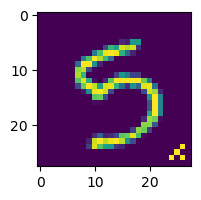

In [25]:
plt.imshow(clients[-1].get_dataset()[0][0].squeeze())

In [26]:
# global_net = to_device(FederatedNet(), device)
history = []
for i in range(15):
    print('Start Round {} ...'.format(i + 1))
    curr_parameters = global_net.get_parameters()
    new_parameters = dict([(layer_name, {'weight': 0, 'bias': 0}) for layer_name in curr_parameters])
    for client in clients:
        client_parameters = client.train(curr_parameters)
        fraction = client.get_dataset_size() / total_train_size
        for layer_name in client_parameters:
            new_parameters[layer_name]['weight'] += fraction * client_parameters[layer_name]['weight']
            new_parameters[layer_name]['bias'] += fraction * client_parameters[layer_name]['bias']
    global_net.apply_parameters(new_parameters)

    # train_loss, train_acc = global_net.evaluate(train_dataset)
    test_loss, test_acc = global_net.evaluate(test_dataset)
    # test_loss, test_acc = global_net.evaluate(target_test_dataset)
    # print('After round {}, train_loss = {}, train_acc = {}, test_loss = {}, test_acc = {}\n'.format(i + 1, round(train_loss, 4),
    #         round(train_acc,4), round(test_loss, 4), round(test_acc, 4)))
    print('After round {}, test_loss = {}, test_acc = {}\n'.format(i + 1, round(test_loss, 4), round(test_acc, 4)))

    history.append((test_loss, test_acc))

Start Round 1 ...
client_0: Loss = 0.2397, Accuracy = 0.9291
client_1: Loss = 0.24, Accuracy = 0.9282
client_2: Loss = 0.2201, Accuracy = 0.9309
client_3: Loss = 0.2345, Accuracy = 0.9306
client_4: Loss = 0.223, Accuracy = 0.9332
client_5: Loss = 0.2307, Accuracy = 0.9333
client_6: Loss = 0.222, Accuracy = 0.9351
client_7: Loss = 0.2339, Accuracy = 0.9275
client_8: Loss = 0.226, Accuracy = 0.9332
client_9: Loss = 0.6356, Accuracy = 0.8118
After round 1, test_loss = 2.369, test_acc = 0.4429

Start Round 2 ...
client_0: Loss = 0.3524, Accuracy = 0.8978
client_1: Loss = 0.3217, Accuracy = 0.9018
client_2: Loss = 0.3475, Accuracy = 0.9022
client_3: Loss = 0.3672, Accuracy = 0.8984
client_4: Loss = 0.349, Accuracy = 0.9042
client_5: Loss = 0.3845, Accuracy = 0.8923
client_6: Loss = 0.3485, Accuracy = 0.8952
client_7: Loss = 0.3622, Accuracy = 0.9007
client_8: Loss = 0.3665, Accuracy = 0.9012
client_9: Loss = 0.3822, Accuracy = 0.8638
After round 2, test_loss = 0.2846, test_acc = 0.951

Star

In [27]:
history

[(2.3689887523651123, 0.44293907284736633),
 (0.28456050157546997, 0.9510482549667358),
 (0.91166090965271, 0.7847112417221069),
 (0.264892041683197, 0.961530864238739),
 (0.4807725250720978, 0.9569817781448364),
 (0.8774300217628479, 0.9683544039726257),
 (14.296042442321777, 0.271558552980423),
 (2.335655450820923, 0.10344145447015762),
 (2.5055248737335205, 0.10047468543052673),
 (2.732556104660034, 0.10047468543052673),
 (2.829801559448242, 0.10047468543052673),
 (3.1818623542785645, 0.10047468543052673),
 (6.4385786056518555, 0.0970134511590004),
 (34.71588897705078, 0.09760680049657822),
 (91.48169708251953, 0.10344145447015762)]

In [29]:
history_test_acc = [x[1] for x in history ]
# newlist = [x for x in fruits if "a" in x]


In [30]:
history_test_acc

[0.44293907284736633,
 0.9510482549667358,
 0.7847112417221069,
 0.961530864238739,
 0.9569817781448364,
 0.9683544039726257,
 0.271558552980423,
 0.10344145447015762,
 0.10047468543052673,
 0.10047468543052673,
 0.10047468543052673,
 0.10047468543052673,
 0.0970134511590004,
 0.09760680049657822,
 0.10344145447015762]

In [33]:
y

array([0.44293907, 0.95104825, 0.78471124, 0.96153086, 0.95698178,
       0.9683544 , 0.27155855, 0.10344145, 0.10047469, 0.10047469,
       0.10047469, 0.10047469, 0.09701345, 0.0976068 , 0.10344145])

In [34]:
x

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

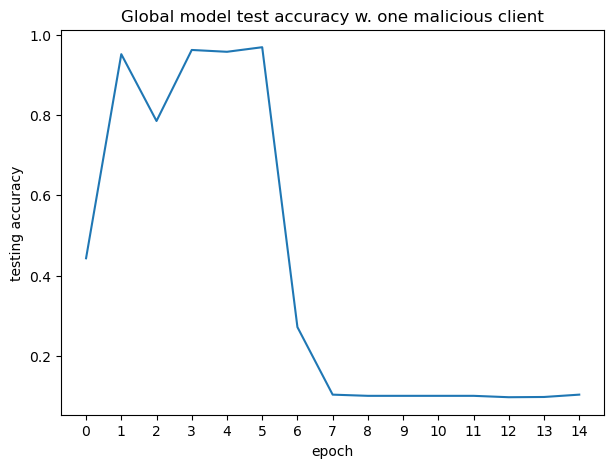

In [43]:
import matplotlib.pyplot as plt 
import numpy as np 
  
# x = np.array([1, 2, 3, 4]) 
x = np.arange(15)
y = np.array(history_test_acc)

plt.figure(figsize=(7,5))

plt.plot(x, y) 
plt.xticks(range(0, len(x)))

plt.xlabel("epoch")  # add X-axis label 
plt.ylabel("testing accuracy")  # add Y-axis label 
plt.title("Global model test accuracy w. one malicious client")  # add title 
plt.show() 


In [35]:
clients[-1].get_dataset()[0][1]

9

In [28]:
clients[-1].get_dataset()[1][1]

9

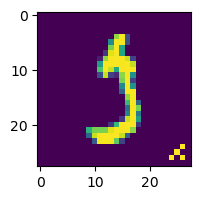

In [29]:
plt.imshow(clients[-1].get_dataset()[1][0].squeeze())

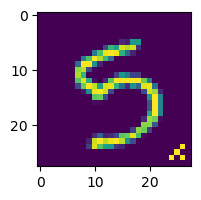

In [30]:
plt.imshow(clients[-1].get_dataset()[0][0].squeeze())

# RETRAIN (NOT YET REVISED)

#Implementing Retrain

Excluding the target client

We considered the last client as a target client

In [31]:
# # @title
# examples_per_client = total_train_size // num_clients
# client_datasets = random_split(train_dataset, [min(i + examples_per_client,
#            total_train_size) - i for i in range(0, total_train_size, examples_per_client)])

# ####################################
# # We should add the backdoor triggers on the last client dataset
# # client_datasets[-1] = ...

# ####################################

# clients = [Client('client_' + str(i), client_datasets[i]) for i in range(num_clients - 1)]

In [32]:
# global_net = to_device(FederatedNet(), device)
# history = []
# for i in range(rounds):
#     print('Start Round {} ...'.format(i + 1))
#     curr_parameters = global_net.get_parameters()
#     new_parameters = dict([(layer_name, {'weight': 0, 'bias': 0}) for layer_name in curr_parameters])
#     for client in clients:
#         client_parameters = client.train(curr_parameters)
#         fraction = client.get_dataset_size() / total_train_size
#         for layer_name in client_parameters:
#             new_parameters[layer_name]['weight'] += fraction * client_parameters[layer_name]['weight']
#             new_parameters[layer_name]['bias'] += fraction * client_parameters[layer_name]['bias']
#     global_net.apply_parameters(new_parameters)

#     train_loss, train_acc = global_net.evaluate(train_dataset)
#     test_loss, test_acc = global_net.evaluate(test_dataset)
#     print('After round {}, train_loss = {}, test_loss = {}, test_acc = {}\n'.format(i + 1, round(train_loss, 4),
#             round(test_loss, 4), round(test_acc, 4)))
#     history.append((train_loss, test_loss))

# Implementing the Unlearning Algorithm